In [1]:
import pandas as pd
import sqlite3
import os
import statsmodels.api as sm
import pylab as pl
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
 
    return conn


def select_from_table(conn, table):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    sql_str = "SELECT * FROM {tb}".format(tb=table)
    cur = conn.cursor()
    cur.execute(sql_str)
    names = [description[0] for description in cur.description]

    rows = cur.fetchall()
    
    df = pd.DataFrame(rows, columns =names) 
   
    return df

In [3]:
data_path = '/Users/awinecoff/Documents/muscularity/data'
os.chdir(data_path)

conn = create_connection('muscularity_sqlite.db')
ht_wt_bmi = select_from_table(conn, 'ht_wt_bmi')
body_decisions = select_from_table(conn, 'body_decisions')
body_image_values = select_from_table(conn, 'body_image_values')
demographics = select_from_table(conn, 'demographics')
validation = select_from_table(conn, 'body_image_validation')

conn.close()

In [14]:

validation_grouped = validation[['size','size_rating', 'gender']].groupby(['size', 'gender']).mean().reset_index()
validation.head(5)
#validation_grouped

,subj,gender,emaciation_rating,detail_rating,size_rating,attractiveness_rating,body_num,detail,size,emaciation
0,1,Male,3,2,2,3,body1,0.0,0.00,0.25
1,1,Male,2,2,1,3,body2,0.0,0.00,0.50
2,1,Male,4,2,2,3,body3,0.0,0.00,0.75
3,1,Male,2,2,2,3,body4,0.0,0.25,0.00
4,1,Male,2,2,1,3,body5,0.0,0.25,0.25


In [ ]:
#list(validation_grouped[validation_grouped['Gender']=='Female']['size_rating'].round(2))

In [5]:
raw_data = {'size': [0.0, 0.25, 0.50, 0.75],
            'female': list(validation_grouped[validation_grouped['gender']=='Female']['size_rating'].round(2)),
            'male': list(validation_grouped[validation_grouped['gender']=='Male']['size_rating'].round(2)),
           }

df = pd.DataFrame(raw_data)
df

,size,female,male
0,0.00,1.77,1.78
1,0.25,2.26,2.03
2,0.50,3.00,2.67
3,0.75,3.54,3.44


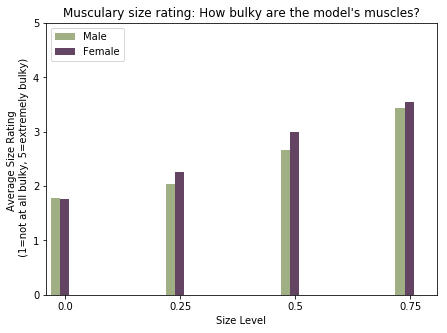

In [12]:
pos = list(range(4))#create a list for the levels of s, d, &e
width = 0.08 
hex_colors = ['#A0AF84', '#634563']
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(7,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['male'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1.0, 
        # with color
        color=hex_colors[0], 
        # with label the first value in first_name
        label='Male') 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['female'],
        # of width
        width, 
        # with alpha 0.5
        alpha=1.0, 
        # with color
        color=hex_colors[1], 
        # with label the second value in first_name
        label='Female') 


# Set the y axis label
ax.set_ylabel('Average Size Rating \n (1=not at all bulky, 5=extremely bulky)')
        
# Set the y axis label
ax.set_xlabel('Size Level')

# Set the chart's title
ax.set_title("Musculary size rating: How bulky are the model's muscles?")

# Set the position of the x ticks
ax.set_xticks([p + 1.1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['0.0', '0.25', '0.5', '0.75'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 5])

# Adding the legend and showing the plot
plt.legend(['Male', 'Female'], loc='upper left')
#plt.grid()
plt.show()

In [32]:
def plot_validation_data(validation_df, dimension):
    
    if dimension == 'size':
        rating = 'size_rating'
        y_lab = 'Average size rating \n (1=not at all bulky, 5=extremely bulky)'
        title = "Model muscle size rating: How bulky are the model's muscles?"
        x_lab = 'Size level'
    elif dimension == 'detail':
        rating = 'detail_rating'
        y_lab = 'Average detail rating \n (1=not at all defined, 5=extremely defined)'
        title = "Model muscle detail rating: How defined are the model's muscles?"
        x_lab = 'Detail level'
    elif dimension == 'emaciation':
        rating = 'emaciation_rating'
        y_lab = 'Average emaciation rating \n (1=not at all visible, 5=extremely visible)'
        title = "Model emaciation rating: How visible is the model's bone structure?"
        x_lab = 'Emaciation level'
    else:
        raise ValueError("Invalid dimension")
    
    validation_grouped = validation_df[[dimension, rating, 'gender']].groupby([dimension, 'gender']).mean().reset_index()

    
    raw_data = {dimension: [0.0, 0.25, 0.50, 0.75],
            'female': list(validation_grouped[validation_grouped['gender']=='Female'][rating].round(2)),
            'male': list(validation_grouped[validation_grouped['gender']=='Male'][rating].round(2)),
           }

    df = pd.DataFrame(raw_data)
    
    pos = list(range(4))#create a list for the levels of s, d, &e
    width = 0.08 
    
    hex_colors = ['#A0AF84', '#634563']

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(8,5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar(pos, 
            #using df['pre_score'] data,
            df['male'], 
            # of width
            width, 
            # with alpha 0.5
            alpha=1.0, 
            # with color
            color=hex_colors[0], 
            # with label the first value in first_name
            label='Male') 

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width for p in pos], 
            #using df['mid_score'] data,
            df['female'],
            # of width
            width, 
            # with alpha 0.5
            alpha=1.0, 
            # with color
            color=hex_colors[1], 
            # with label the second value in first_name
            label='Female') 


    # Set the y axis label
    ax.set_ylabel(y_lab)

    # Set the y axis label
    ax.set_xlabel(x_lab)

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.01 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(['0.0', '0.25', '0.5', '0.75'])

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    plt.ylim([0, 5])

    # Adding the legend and showing the plot
    plt.legend(['Male', 'Female'], loc='upper left')
    plt.tight_layout()
    #plt.grid()
    plt.show()

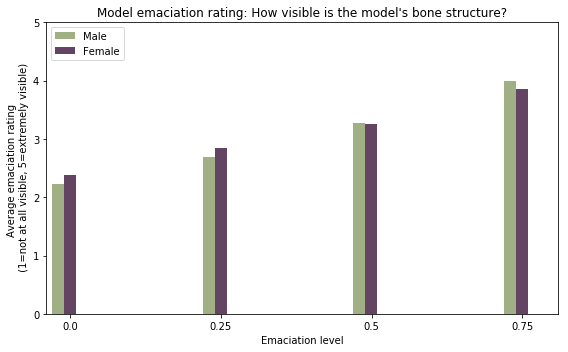

In [33]:
plot_validation_data(validation, 'emaciation')

In [ ]:
demographics = demographics[['subj', 'sport', 'gender', 'age', 'education', 'race', 'frequency', 'duration', 'percent women']]
demographics_plus = pd.merge(demographics, ht_wt_bmi, on='subj', how='left').dropna()
demographics_plus['BMI'] = pd.to_numeric(demographics_plus['BMI'],errors='coerce').round(1)#round BMI so it can be more easily plotted later
demographics_plus = demographics_plus[(demographics_plus['BMI'] > 14) & (demographics_plus['BMI'] < 35)]#remove implausible BMI values
demographics_plus.sort_values('BMI', ascending=True)

In [ ]:
body_decisions_long=pd.melt(body_decisions,id_vars=['subj'],var_name='body_num', value_name='choice').sort_values(['subj'])
body_decisions_long.head(5)

body_image_values.head(5)

In [ ]:
body_choice_df = pd.merge(body_decisions_long, body_image_values, on='body_num', how='left')
body_choice_df = pd.merge(body_choice_df, demographics, on='subj',how='left')
body_choice_df.loc[:,'chose_ref'] = [1 if x == y else 0 for x,y in zip(body_choice_df['ref_side'], body_choice_df['choice'])] 
body_choice_df.loc[:,'chose_test'] = [1 if x != y else 0 for x,y in zip(body_choice_df['ref_side'], body_choice_df['choice'])] 
body_choice_df.head(5)

In [ ]:
def plot_hist_by_sport(df, continuous_var, bins):
    df = df.dropna()
    
    run = list(df[df['sport'] == 'Running'][continuous_var])
    rc = list(df[df['sport'] == 'Rock climbing'][continuous_var])
    cf = list(df[df['sport'] == 'CrossFit'][continuous_var])

    # Assign colors for each airline and the names
    colors = ['#A0AF84', '#634563', '#FC7358']
    names = ['Running', 'Rock Climbing', 'CrossFit']

    # Make the histogram using a list of lists
    # Normalize the flights and assign colors and names
    plt.hist([run, rc, cf], bins = bins,
             color = colors, label=names)

    # Plot formatting
    plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})
    plt.legend()
    plt.xlabel(continuous_var.capitalize())
    plt.ylabel('Count')
    plt.title('Distribution of {cv} by Sport'.format(cv=continuous_var.capitalize()))


In [ ]:
plot_hist_by_sport(demographics_plus, 'education', 10)

In [ ]:
def extract_level_df(df, categorial_var):

    level_list = []
    for c in df.columns:
        if att in c:
            level_list.append(c)

    level_df = df[level_list]

    return level_df


In [ ]:
race_by_sport = demographics_plus[['subj', 'sport','race']].groupby(['sport','race']).count().reset_index()

race_by_sport

In [ ]:
def make_sport_pie_chart(df, sport, categorical_var):
    
    var_by_sport = df[['subj', 'sport',categorical_var]].groupby(['sport',categorical_var]).count().reset_index()
    all_levels = set(var_by_sport[categorical_var])
    
    sport_df = var_by_sport[var_by_sport['sport']==sport]
    sport_levels = set(sport_df[categorical_var])
    
    #If the sport does not have all the levels that the other sports have, add in a zero count for the missing levels
    if (all_levels != sport_levels) & (categorical_var != 'percent women'):

        missing_levels = list(all_levels.difference(sport_levels))

        missing_dict = [{'sport':sport, categorical_var:l, 'subj':0} for l in missing_levels]
        missing_df = pd.DataFrame(missing_dict)
        sport_df = pd.concat([sport_df, missing_df], sort=True)


    sport_df = sport_df.sort_values(by=categorical_var)
    
    x=sport_df[categorical_var]
    y=sport_df['subj']

    colors = ["#7d2841","#514626","#007469",
    "#629957",
    "#cf9ead",
    "#a0a252",
    ]
    percent = 100.*y/y.sum()

    patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
    labels = ['{0} ({1:1.1f}%)'.format(i,j) for i,j in zip(x, percent)]

    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                              key=lambda x: x[2],
                                              reverse=False))

    plt.legend(patches, labels, bbox_to_anchor=(0.1, 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0., prop={'size': 12}, frameon=False)

    # View the plot
    plt.tight_layout()
    plt.show()
    #plt.savefig('piechart.png', bbox_inches='tight')

In [ ]:
make_sport_pie_chart(demographics_plus, 'Rock climbing', 'percent women')

In [ ]:
model_data_all = body_choice_df.dropna()
model_data_all.head(5)

In [ ]:
print("Length of df for all is {}".format(len(model_data_all)))
model_data_female = model_data_all[model_data_all['gender']=='Female']
model_data_male = model_data_all[model_data_all['gender']=='Male']

#Use running as the reference group
female_mod_run =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Running'))*size + C(sport, Treatment(reference='Running'))*detail + C(sport, Treatment(reference='Running'))*emaciation + C(sport, Treatment(reference='Running'))*age", data = model_data_female)
male_mod_run =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Running'))*size + C(sport, Treatment(reference='Running'))*detail + C(sport, Treatment(reference='Running'))*emaciation + C(sport, Treatment(reference='Running'))*age", data = model_data_male)



f_result_run = female_mod_run.fit()
m_result_run = male_mod_run.fit()




In [ ]:
print (f_result_run.summary())

In [ ]:
female_mod_rc =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Rock climbing'))*size + C(sport, Treatment(reference='Rock climbing'))*detail + C(sport, Treatment(reference='Rock climbing'))*emaciation + C(sport, Treatment(reference='Rock climbing'))*age", data = model_data_female)
male_mod_rc =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Rock climbing'))*size + C(sport, Treatment(reference='Rock climbing'))*detail + C(sport, Treatment(reference='Rock climbing'))*emaciation + C(sport, Treatment(reference='Rock climbing'))*age", data = model_data_male)

female_mod_cf =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='CrossFit'))*size + C(sport, Treatment(reference='CrossFit'))*detail + C(sport, Treatment(reference='CrossFit'))*emaciation + C(sport, Treatment(reference='CrossFit'))*age", data = model_data_female)
male_mod_cf =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='CrossFit'))*size + C(sport, Treatment(reference='CrossFit'))*detail + C(sport, Treatment(reference='CrossFit'))*emaciation + C(sport, Treatment(reference='CrossFit'))*age", data = model_data_male)

f_result_rc = female_mod_rc.fit()
m_result_rc = male_mod_rc.fit()

f_result_run = female_mod_cf.fit()
m_result_run = male_mod_cf.fit()

In [ ]:
print (f_result_rc.summary())